In [1]:
import numpy as np
import struct
from array import array
import os
from os.path  import join
import random as rn
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import time
import itertools
import matplotlib as mpl
import pandas as pd

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.random_projection import SparseRandomProjection

In [2]:
"""
Got this code from https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook for 
instructions on how to load data from the MNIST dataset
"""
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
#             img = img.reshape(28, 28)
            images[i][:] = img            
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

In [3]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = 'data/mnist_datafolder'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [4]:
"""
Setting up seed values for reproducability
"""
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
"""
Getting the size values for the training and testing dataset
"""
size_train_samples = np.shape(x_train)[0]
size_test_samples = np.shape(x_test)[0]
print(np.shape(x_train)[1])

784


In [17]:
"""
Taking a subset of the MNIST dataset since the 60000 it is doing is taking very long
"""

subset_size = 10000

random_indexes = np.random.choice(size_train_samples, subset_size, replace = False)
x_train_subset = np.take(x_train, random_indexes, axis=0)
y_train_subset = np.take(y_train, random_indexes)

In [18]:
"""
Running Sparse Randomized Projections on the MNIST Dataset to achieve Dimension Reductionality.
This method is to find the best number of components based on the Reconstruction Error score.
"""

n_components_range = list(range(0, 800, 50))
n_components_range[0] = 2
n_components_range[-1] = 784

# Hyperparameters for RP
density = 'auto'
eps = 0.1
compute_inverse_components = True
dense_output = False

# Scores for the reconstruction error
reconstruction_error_scores = []

for n_components in n_components_range:
    print(f"Trying {n_components}...")
    rp = SparseRandomProjection(
        n_components = n_components,
        density = density,
        eps = eps,
        compute_inverse_components = compute_inverse_components,
        dense_output = dense_output,
        random_state = seed
    )
    
    x_transformed = rp.fit_transform(x_train_subset)
    x_projected = rp.inverse_transform(x_transformed)
    
    reconstruction_error_scores.append(np.sum((x_train_subset - x_projected) ** 2, axis=1).mean())


Trying 2...
Trying 50...
Trying 100...
Trying 150...
Trying 200...
Trying 250...
Trying 300...
Trying 350...
Trying 400...
Trying 450...
Trying 500...
Trying 550...
Trying 600...
Trying 650...
Trying 700...
Trying 784...


Text(0.5, 1.0, 'Reconstruction Error vs Number of Components on RP')

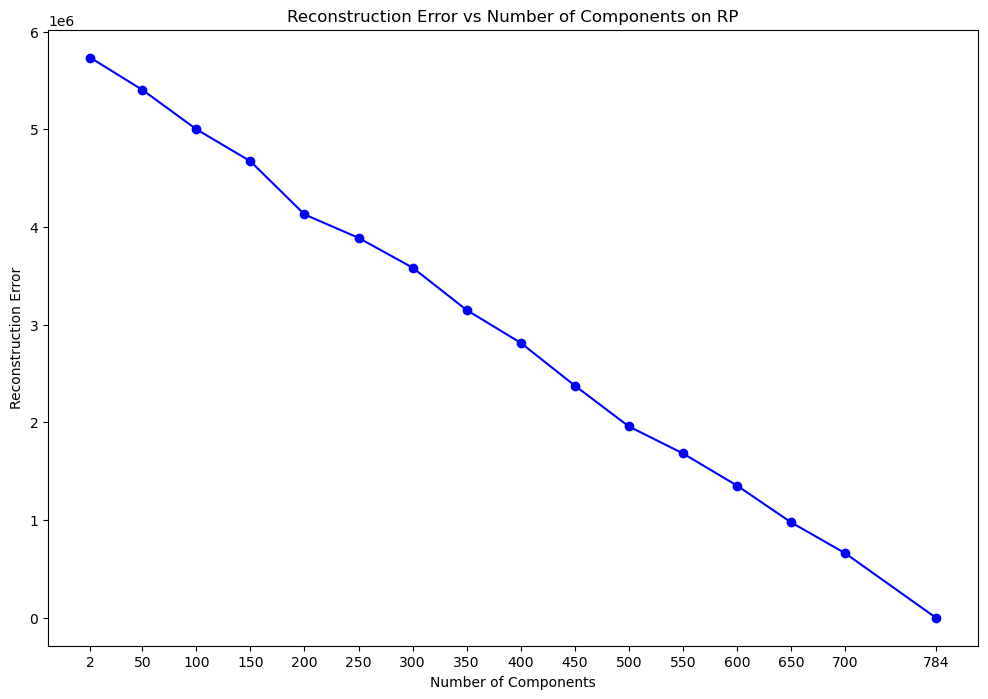

In [19]:
"""
First showing the Reconstruction Error plot to find where the loss is a minimum.
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_components_range, reconstruction_error_scores, '-o', color='blue')
ax.set(xlabel='Number of Components', ylabel='Reconstruction Error')
ax.set_xticks(n_components_range)
ax.set_title('Reconstruction Error vs Number of Components on RP')

In [20]:
"""
The analysis above showed us that the Reconstruction Error value is at a good point around 650. Let's use that 
for our dimensional reduction
"""
rpfinal = SparseRandomProjection(
    n_components = 650,
    density = density,
    eps = eps,
    compute_inverse_components = compute_inverse_components,
    dense_output = dense_output,
    random_state = seed
)

rpfinal.fit(x_train_subset)

x_train_transformed = rpfinal.transform(x_train_subset)

In [21]:
"""
Apply Gaussian Mixture Modeling Clustering on this new dataset
"""

# Range of Gaussians we should try
gaussian_range_size = range(2, 13)

# Hyperparameters for GaussianMixtureModel
covariance_type = "full"
tol = 1e-3
reg_covar = 1e-6
max_iter = 100
n_init = 1
init_params = "kmeans"

# Lists to keep track the BIC and AIC scores across number of Gaussians
bic_scores = []
aic_scores = []
siloutte_scores = []

for gaussian_size in gaussian_range_size:
    print(f"Trying size {gaussian_size}...")
    gm = GaussianMixture(
        n_components = gaussian_size,
        covariance_type = covariance_type,
        tol = tol,
        reg_covar = reg_covar,
        max_iter = max_iter,
        init_params = init_params,
        n_init = n_init,
        random_state = seed
    )
    
    gm.fit(x_train_transformed)
    labels = gm.predict(x_train_transformed)
    
    bic_scores.append(gm.bic(x_train_transformed))
    aic_scores.append(gm.aic(x_train_transformed))
    siloutte_scores.append(silhouette_score(x_train_transformed, labels, metric='euclidean'))
    


Trying size 2...
Trying size 3...
Trying size 4...
Trying size 5...
Trying size 6...
Trying size 7...
Trying size 8...
Trying size 9...
Trying size 10...
Trying size 11...
Trying size 12...


Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Gaussians')

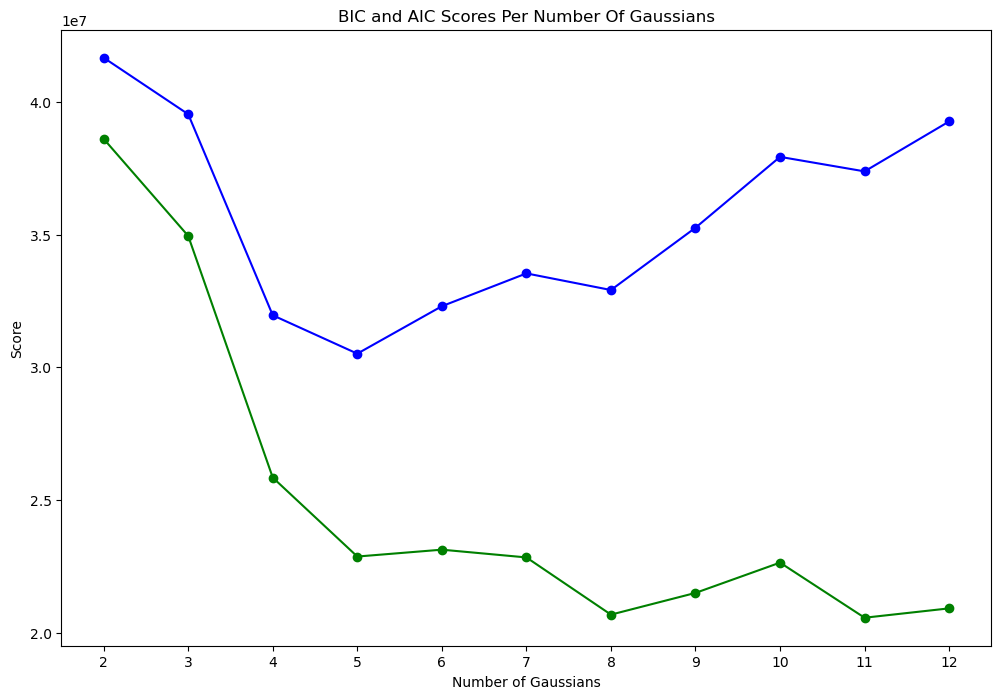

In [22]:
"""
Plotting the AIC vs BIC graph
"""
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(gaussian_range_size, bic_scores, '-o', color='blue')
ax.plot(gaussian_range_size, aic_scores, '-o', color='green')
ax.set(xlabel='Number of Gaussians', ylabel='Score')
ax.set_xticks(gaussian_range_size)
ax.set_title('BIC and AIC Scores Per Number Of Gaussians')

Text(0.5, 1.0, 'Siloutte Scores Per Number Of Gaussians')

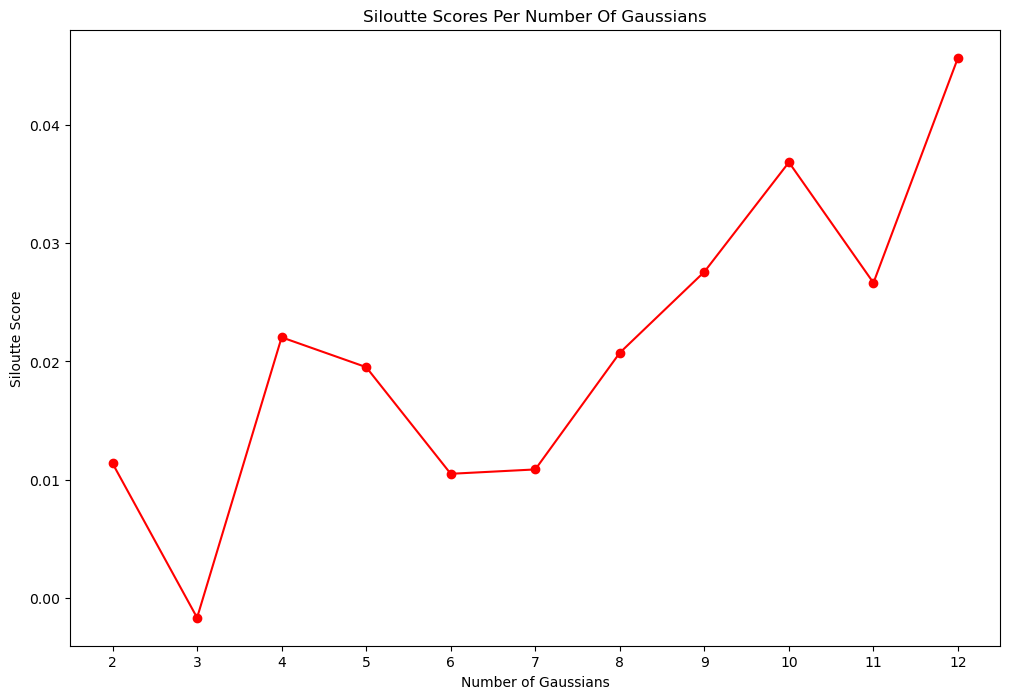

In [23]:
"""
Plotting the Siloutte Scores
"""
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(gaussian_range_size, siloutte_scores, '-o', color='red')
ax.set(xlabel='Number of Gaussians', ylabel='Siloutte Score')
ax.set_xticks(gaussian_range_size)
ax.set_title('Siloutte Scores Per Number Of Gaussians')

In [24]:
"""
Apply Kmeans Clustering to the new transformed dataset
"""

# Range of Clusters we should try
k_range = range(2, 13)

# Hyperparameters for KMeans
init = "random"
n_init = 10
max_iter = 300
algorithm = "full"

# Lists to keep track the metric scores
inertia_scores = []
davies_bouldin_scores = []
siloutte_scores = []

for k in k_range:
    print(f"Trying size {k}...")
    km = KMeans(
        n_clusters = k,
        init = init,
        n_init = n_init,
        max_iter = max_iter,
        algorithm = algorithm,
        random_state = seed
    )
    
    km.fit(x_train_transformed)
    labels = km.labels_
    
    inertia_scores.append(km.inertia_)
    siloutte_scores.append(silhouette_score(x_train_transformed, labels, metric='euclidean'))
    davies_bouldin_scores.append(davies_bouldin_score(x_train_transformed, labels))
    


Trying size 2...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 3...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 4...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 5...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 6...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 7...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 8...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 9...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 10...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 11...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 12...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Text(0.5, 1.0, 'Number of K and Effect on Inertia Scores')

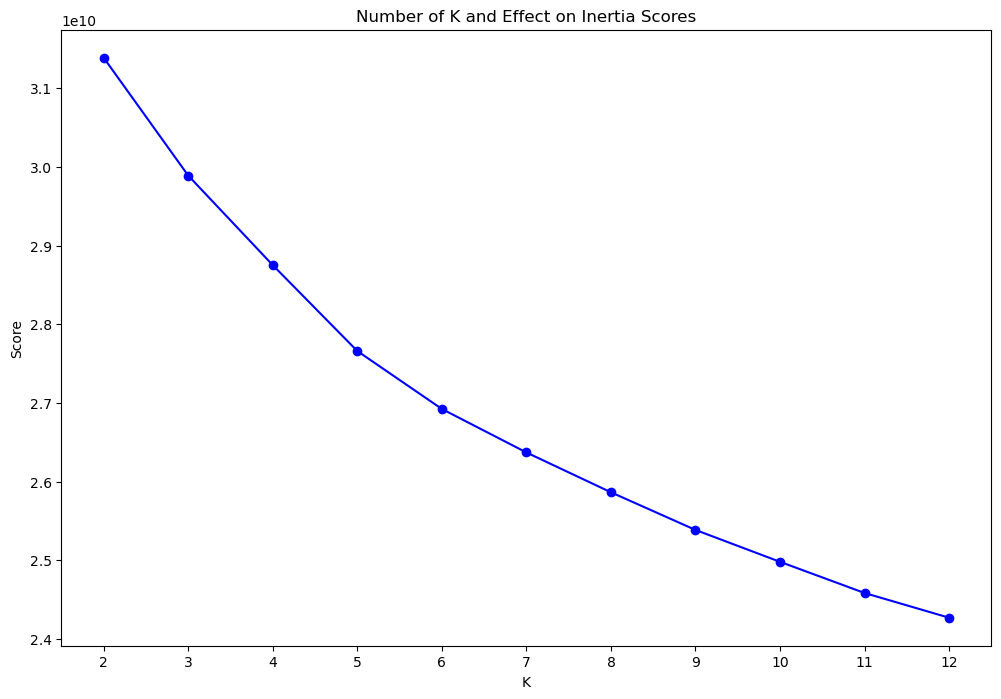

In [25]:
"""
Plotting the inertia scores from the clustering 
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(k_range, inertia_scores, '-o', color='blue')
ax.set(xlabel='K', ylabel='Score')
ax.set_xticks(k_range)
ax.set_title('Number of K and Effect on Inertia Scores')

Text(0.5, 1.0, 'Number of K and Effect on Silhouette Scores')

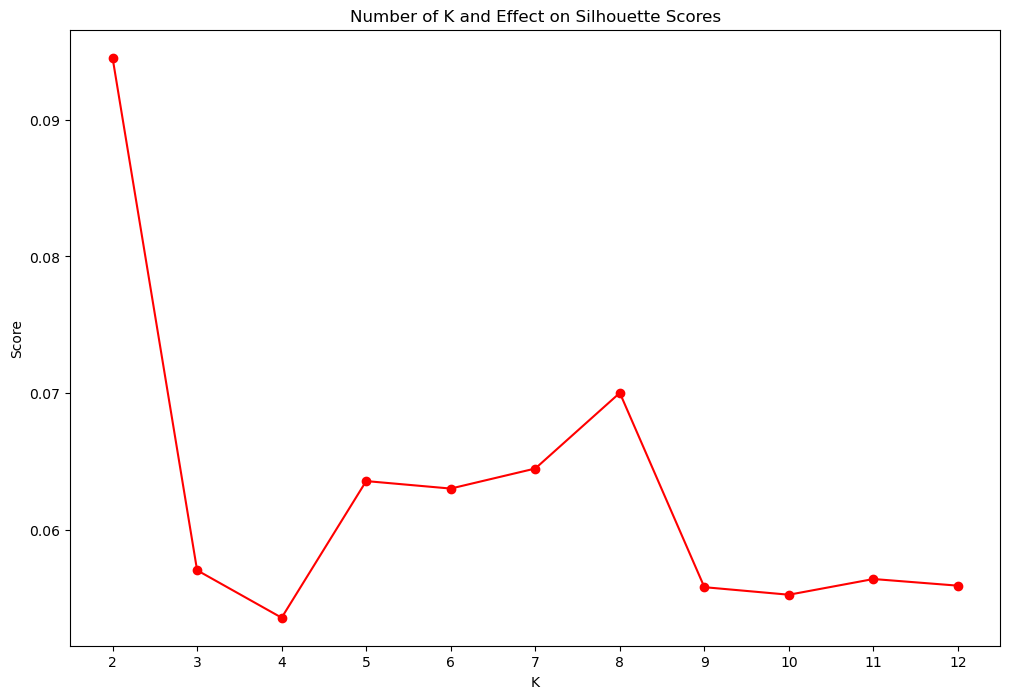

In [26]:
"""
Plotting the Siloutte Scores from the clustering
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(k_range, siloutte_scores, '-o', color='red')
ax.set(xlabel='K', ylabel='Score')
ax.set_xticks(k_range)
ax.set_title('Number of K and Effect on Silhouette Scores')

Text(0.5, 1.0, 'Number of K and Effect on Davies Bouldin Scores')

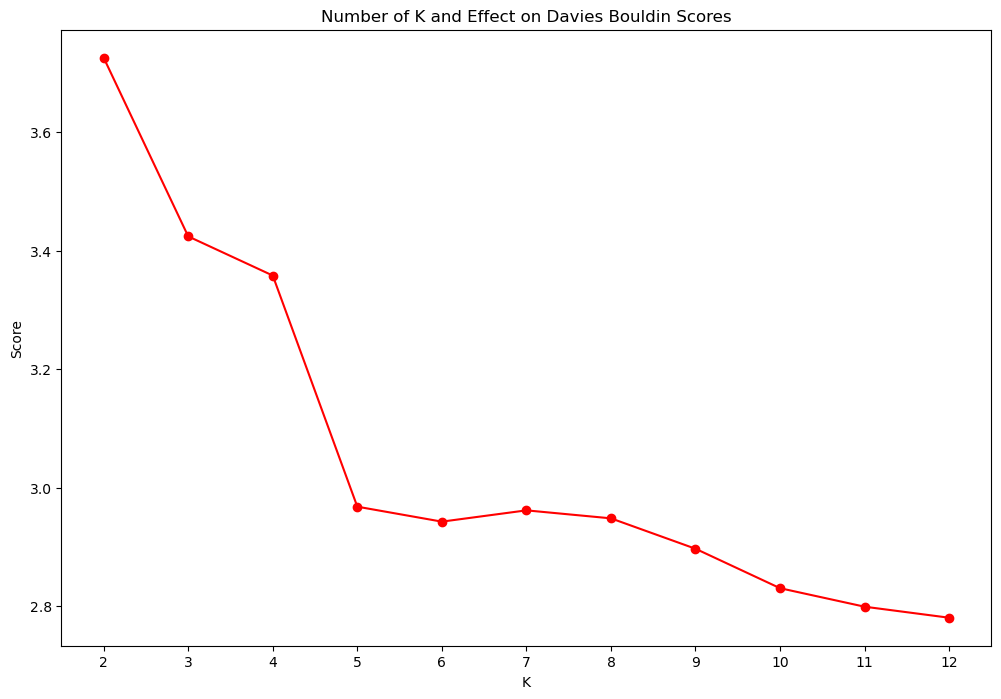

In [27]:
"""
Plotting the Davies Bouldin Scores from the clustering
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(k_range, davies_bouldin_scores, '-o', color='red')
ax.set(xlabel='K', ylabel='Score')
ax.set_xticks(k_range)
ax.set_title('Number of K and Effect on Davies Bouldin Scores')